Binary classification problem

https://github.com/EffiSciencesResearch/ML4G/blob/main/days/w1d2/hyperparameters/TP1_Ex1_Binary_classification_solution.ipynb

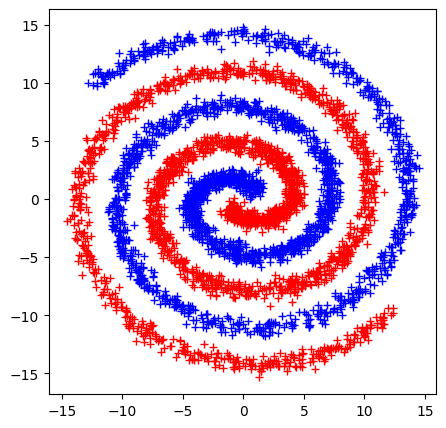

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Display figures on jupyter notebook
%matplotlib inline


# Define a function to generate the dataset, in the form of two interlaced spirals
def spiral(phi):
    x = (phi+1)*torch.cos(phi)
    y = phi*torch.sin(phi)
    return torch.cat((x, y), dim=1)

def generate_data(num_data):
    angles = torch.empty((num_data, 1)).uniform_(1, 15)
    data = spiral(angles)
    # add some noise to the data
    data += torch.empty((num_data, 2)).normal_(0.0, 0.4)
    labels = torch.zeros((num_data,), dtype=torch.int)
    # flip half of the points to create two classes
    data[num_data//2:,:] *= -1
    labels[num_data//2:] = 1
    return data, labels

# Generate the training set with 4000 examples by function generate_data

X_train, y_train = generate_data(4000)
X_train.size()

# Define the vis_data function to visualize the dataset
def vis_data(X, y):
    plt.figure(figsize=(5, 5))
    plt.plot(X[y==1, 0], X[y==1, 1], 'r+') #Examples are represented as red plusses for label 1
    plt.plot(X[y==0, 0], X[y==0, 1], 'b+') #Examples are represented as blue plusses for label 0 


vis_data(X_train, y_train) # visualize training set

/tmp/ipykernel_8925/4234405538.py:56: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


Accuracy of the network on the 1000 validation data: 59.90 %


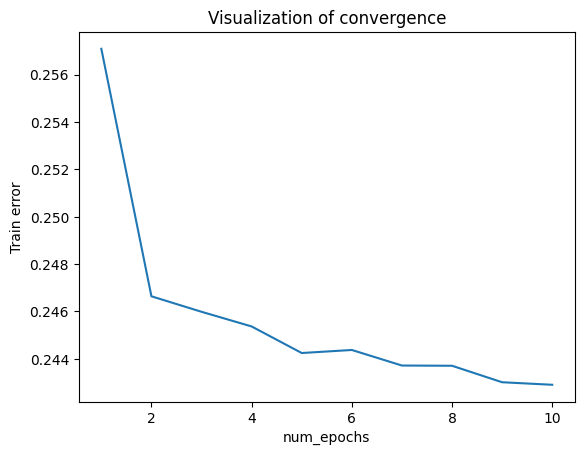

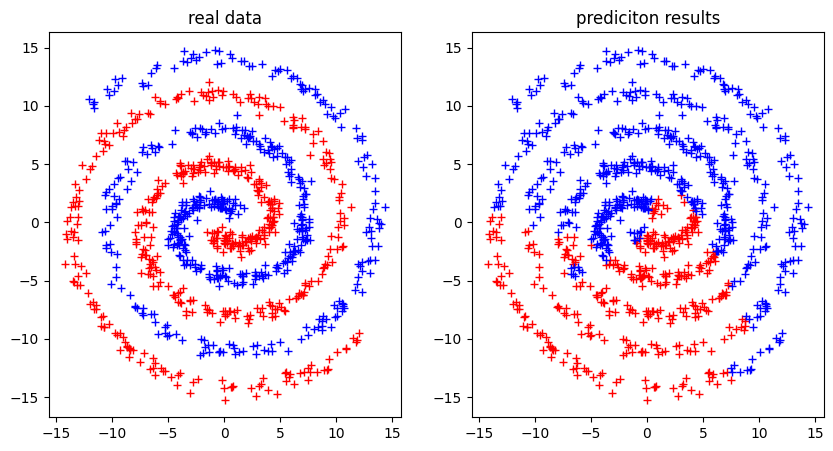

In [3]:
from torch.utils.data import TensorDataset, DataLoader
training_set = TensorDataset(X_train, y_train)

import torch.nn as nn
import torch.nn.functional as F

from typing_extensions import Literal

# Basic network structure with a single layer
class Model(nn.Module):
    
    def __init__(self, layers=[2, 10,1], non_linearity : Literal["relu", "sigmoid", "tanh"] = "relu"):
        super(Model, self).__init__()
        # A single linear layer
        # The model has 2 inputs (the coordinates of the point) and an output (the prediction)
        sequence = [nn.Linear(layers[i-1], layers[i]) for i in range(1, len(layers))]
        non_lin = nn.ReLU() if non_linearity == "relu" else nn.Sigmoid()
        non_lin  = nn.Tanh() if non_linearity == "tanh" else non_lin
        sequence_with_non_lin = []
        for lin in sequence :
            sequence_with_non_lin.append(lin)
            sequence_with_non_lin.append(non_lin)

        self.seq = nn.Sequential(
            *sequence_with_non_lin[:-1]
        )
     
        
    def forward(self, inputs):
        # We want the model to predict 0 for one class and 1 for the other class
        # A Sigmoid activation function seems appropriate
        h = self.seq(inputs)
        outputs = torch.sigmoid(h)
        
        return outputs
    

# Create the model: 
model = Model()

# Choose the hyperparameters for training: 
num_epochs = 10
batch_size = 10

# Training criterion. This one is a mean squared error (MSE) loss between the output
# of the network and the target label
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)



# define a function for training
from tqdm.autonotebook import tqdm

def train(num_epochs, batch_size, criterion, optimizer, model, dataset, verbose=0):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train()
    for epoch in tqdm(range(num_epochs)):
        epoch_average_loss = 0.0
        for (X_batch, y_real) in train_loader:
            y_pre = model(X_batch).view(-1)
            loss = criterion(y_pre, y_real.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        if verbose:
            print('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss))
    return train_error


train_error = train(num_epochs, batch_size, criterion, optimizer, model, training_set)

# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")

# Generate 1000 validation data:
X_val, y_val = generate_data(1000)



# predict labels for validation set
model.eval() # set the model to test mode
with torch.no_grad():
    y_pre = model(X_val).view(-1)
    #loss = criterion(y_val, y_pre.float())
    #print(loss.item())




# Calculate the accuracy on validation set to evaluate the model by the function accuracy
def accuracy(y_real, y_pre):
    y_pre[y_pre<0.5] = 0
    y_pre[y_pre>=0.5] = 1

    acc = 1 - torch.sum(torch.abs(y_pre - y_real))/len(y_pre)
    print('Accuracy of the network on the 1000 validation data: {:.2f} %'.format(acc.item()*100))
    return acc.item()




accuracy(y_val, y_pre)


# Compare the prediction with real labels

def compare_pred(X, y_real, y_pre):
    plt.figure(figsize=(10, 5))

    plt.subplot(121)
    plt.plot(X[y_real==1, 0], X[y_real==1, 1], 'r+') #Examples are represented as a red plusses for label 1
    plt.plot(X[y_real==0, 0], X[y_real==0, 1], 'b+') #Examples are represented as a blue plusses for label 0
    plt.title("real data")

    plt.subplot(122)
    plt.plot(X[y_pre==1, 0], X[y_pre==1, 1], 'r+')
    plt.plot(X[y_pre==0, 0], X[y_pre==0, 1], 'b+')
    plt.title("prediciton results")





compare_pred(X_val, y_val, y_pre)





